# Stadium Billiard Assignment — Analytic Simulation

This notebook implements a clean, analytic stadium billiard simulator as required for the assignment below.

---

## **Assignment Question (from Tassignment1.pdf)**

### **Stadium Billiard**

A stadium billiard consists of a rectangle of width $2a$ and height $2b$, capped at each end by a half-ellipse of semi-axes $r_x$ (horizontal) and $r_y$ (vertical). A point particle moves freely inside the stadium, bouncing elastically off the boundary.

---

### **(a) Write down the equations for the boundary of the stadium, and describe the conditions for a collision with each part of the boundary.**

---

### **Stadium Boundary Equations**

The boundary of the stadium consists of:

1. **Rectangle (centered at origin):**

    $$ |x| \leq a, \quad |y| \leq b $$

2. **Left ellipse cap (centered at $x = -a$):**

    $$ \frac{(x + a)^2}{r_x^2} + \frac{y^2}{r_y^2} = 1 $$

3. **Right ellipse cap (centered at $x = +a$):**

    $$ \frac{(x - a)^2}{r_x^2} + \frac{y^2}{r_y^2} = 1 $$

---

### **Collision Conditions**

- **Horizontal walls:**  
  Collision occurs when $y = +b$ or $y = -b$ and $|x| \leq a$.

- **Ellipse caps:**  
  Collision occurs when the particle reaches the ellipse boundary at $x = \pm a$ and satisfies:  
  $$ \frac{(x \mp a)^2}{r_x^2} + \frac{y^2}{r_y^2} = 1 $$

- **Note:**  
  Only collisions with horizontal walls and ellipse caps are considered; there are no vertical-wall reflections at $x = \pm a$.
  

In [22]:
import numpy as np
import random
import matplotlib.pyplot as plt
from math import isfinite

# Stadium parameters
# Rectangle: |x| <= a, |y| <= b
# Ellipse caps: centered at x=±a, semi-axes rx, ry

a = 1.0   # half-width of rectangle
b = 1.0   # half-height of rectangle
rx = 2.0  # ellipse semi-axis in x (caps)
ry = b    # ellipse semi-axis in y
EPS = 1e-9


In [23]:
def ellipse_quadratic_coeffs(x0, y0, vx, vy, cx):
    # ellipse centered at (cx,0): ((x-cx)/rx)^2 + (y/ry)^2 = 1
    dx0 = x0 - cx
    A = (vx*vx)/(rx*rx) + (vy*vy)/(ry*ry)
    B = 2*(dx0*vx)/(rx*rx) + 2*(y0*vy)/(ry*ry)
    C = (dx0*dx0)/(rx*rx) + (y0*y0)/(ry*ry) - 1.0
    return A, B, C

def solve_quadratic(A, B, C):
    # robust quadratic solver for real roots; returns sorted positive roots list
    if abs(A) < 1e-18:
        if abs(B) < 1e-18:
            return []
        t = -C / B
        return [t] if isfinite(t) else []
    disc = B*B - 4*A*C
    if disc < 0:
        return []
    sqrt_d = np.sqrt(disc)
    t1 = (-B - sqrt_d) / (2*A)
    t2 = (-B + sqrt_d) / (2*A)
    roots = []
    for t in (t1, t2):
        if isfinite(t):
            roots.append(t)
    roots = sorted(set(roots))
    return roots

def ellipse_normal_at(x, y, cx):
    # gradient of F = (x-cx)^2/rx^2 + y^2/ry^2 - 1 gives normal ~ ((x-cx)/rx^2, y/ry^2)
    nx = (x - cx)/(rx*rx)
    ny = y/(ry*ry)
    v = np.array([nx, ny])
    norm = np.linalg.norm(v)
    if norm == 0:
        return np.array([1.0, 0.0])
    return v / norm

def reflect(v, n):
    # reflect velocity vector v about (unit) normal n
    return v - 2*np.dot(v, n)*n


In [24]:
def simulate_trajectory(x0, y0, vx0, vy0, dt=0.01, steps=10000, max_bounces=None, eps_nudge=1e-9):
    """Analytic stadium billiard: rectangle + ellipse caps, no vertical-wall reflections.
    Returns X, Y, vx, vy, bounces (list of (index, x, y, kind)).
    """
    x, y = float(x0), float(y0)
    vx, vy = float(vx0), float(vy0)
    X = [x]
    Y = [y]
    bounces = []
    bounce_count = 0
    for step in range(steps):
        remaining = dt
        while remaining > 1e-16:
            candidates = []
            # horizontal walls y = +b and -b (priority 1)
            if abs(vy) > 1e-16:
                for wall_y in (b, -b):
                    t = (wall_y - y)/vy
                    if t > 1e-15 and t <= remaining + 1e-15:
                        x_at = x + vx*t
                        if abs(x_at) <= a + 1e-12:
                            ny = 1.0 if wall_y > 0 else -1.0
                            if np.dot(np.array([vx, vy]), np.array([0.0, ny])) > 1e-12:
                                candidates.append((t, 1, 'hwall', wall_y, None))
            # ellipse caps: center at +a and -a (priority 0)
            for sx in (1.0, -1.0):
                cx = sx * a
                A, B, C = ellipse_quadratic_coeffs(x, y, vx, vy, cx)
                roots = solve_quadratic(A, B, C)
                for t in roots:
                    if t > 1e-15 and t <= remaining + 1e-15:
                        x_at = x + vx*t
                        y_at = y + vy*t
                        if sx > 0 and x_at >= a - 1e-12:
                            n_ = ellipse_normal_at(x_at, y_at, cx)
                            if np.dot(np.array([vx, vy]), n_) > 1e-12:
                                candidates.append((t, 0, 'ellipse', cx, sx))
                        if sx < 0 and x_at <= -a + 1e-12:
                            n_ = ellipse_normal_at(x_at, y_at, cx)
                            if np.dot(np.array([vx, vy]), n_) > 1e-12:
                                candidates.append((t, 0, 'ellipse', cx, sx))
            if not candidates:
                x += vx * remaining
                y += vy * remaining
                remaining = 0.0
                break
            candidates.sort(key=lambda c: (c[0], c[1]))
            t_coll, _, kind, param, extra = candidates[0]
            x = x + vx * t_coll
            y = y + vy * t_coll
            if kind == 'hwall':
                ny = 1.0 if param > 0 else -1.0
                n = np.array([0.0, ny])
                v_ref = reflect(np.array([vx, vy]), n)
            else:
                cx = param
                n = ellipse_normal_at(x, y, cx)
                v_ref = reflect(np.array([vx, vy]), n)
            bounce_count += 1
            bounces.append((len(X), x, y, kind))
            v_ref = np.array(v_ref, dtype=float)
            speed = np.hypot(v_ref[0], v_ref[1])
            if speed > 0:
                v_ref = v_ref * (np.hypot(vx, vy) / speed)
            vx, vy = float(v_ref[0]), float(v_ref[1])
            vnorm = np.hypot(vx, vy)
            if vnorm > 0:
                x += (vx / vnorm) * eps_nudge
                y += (vy / vnorm) * eps_nudge
            remaining -= t_coll
            if max_bounces is not None and bounce_count >= max_bounces:
                remaining = 0.0
                break
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y), vx, vy, bounces


bounces recorded = 402
final velocity: 1.355461693344288 0.4033901311091025 speed: 1.4142135623730892


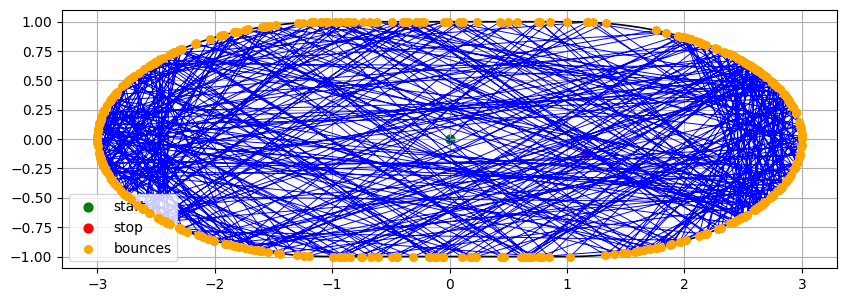

In [45]:
# Run and plot clean stadium billiard trajectory
X, Y, vx_final, vy_final, bounces = simulate_trajectory(0.0, 0.0, 1, 1, dt=0.019, steps=40000, eps_nudge=1e-8)
print('bounces recorded =', len(bounces))
print('final velocity:', vx_final, vy_final, 'speed:', np.hypot(vx_final, vy_final))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(X, Y, '-b', lw=0.7)
ax.scatter([X[0]], [Y[0]], c='green', s=40, label='start')
ax.scatter([X[-1]], [Y[-1]], c='red', s=40, label='stop')
# Stadium boundary
Xt = np.linspace(-a, a, 200)
Yt = np.full_like(Xt, b)
Xb_right = a + rx * np.cos(np.linspace(np.pi/2, -np.pi/2, 200))
Yb_right = ry * np.sin(np.linspace(np.pi/2, -np.pi/2, 200))
Xb_full = np.concatenate([Xt, Xb_right, Xt[::-1], -Xb_right[::-1]])
Yb_full = np.concatenate([Yt, Yb_right, -Yt, Yb_right[::-1]])
ax.plot(Xb_full, Yb_full, 'k-', lw=1.2)
# Overlay bounces
if len(bounces) > 0:
    bx = [p[1] for p in bounces]
    by = [p[2] for p in bounces]
    ax.scatter(bx, by, c='orange', s=30, zorder=20, label='bounces')
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.savefig('stadium_billiard_clean.png', dpi=120)
plt.show()
